In [2]:
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import matplotlib.pyplot as plt
from skimage import transform

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add, Subtract
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D ,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, Nadam, RMSprop
from keras.layers.core import Lambda
from keras.layers.merge import _Merge
from keras.engine.topology import Layer
import datetime
import sys

import gc
from copy import deepcopy

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from keras import backend as K
from keras import initializers
from keras import regularizers
from sklearn.model_selection import TimeSeriesSplit
from keras.models import load_model  

%matplotlib inline
%load_ext autoreload
%autoreload 2

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Using TensorFlow backend.


加载  预处理数据

In [3]:
# 交通矩阵为 matrix_length*matrix_length
matrix_length = 32

matrix_df = pd.read_csv('./data/trafficV_M.csv', index_col=0, parse_dates=True)

In [4]:
# def createTrainArray(week_history_num=0, minute_history_num=0):
#     week_delta_list = [pd.Timedelta(i+1, unit='W') for i in range(week_history_num)]
#     minute_delta_list = [pd.Timedelta((i+1)*15, unit='m') for i in range(minute_history_num)]
#     # 参考历史数据时间点list
#     delta_list = week_delta_list+minute_delta_list
#     print(delta_list)
    
#     set_up_time = pd.Timedelta(week_history_num, unit='W')
#     # 根据历史数据选取多少，重新构建数据集
#     # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
#     train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
#     train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
#     train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
#     # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
#     train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
#     print(train_array.shape)
#     return train_array



def createTrainArray(week_history_num=0, minute_history_num=0):
    week_delta_list = [pd.Timedelta(week_history_num-i, unit='W') for i in range(week_history_num)]
    minute_delta_list = [pd.Timedelta((minute_history_num-i)*15, unit='m') for i in range(minute_history_num)]
    # 参考历史数据时间点list
    delta_list = minute_delta_list+week_delta_list
    print(delta_list)
    
    set_up_time = pd.Timedelta(week_history_num, unit='W')
    # 根据历史数据选取多少，重新构建数据集
    # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
    train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
    train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
    train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
    # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
    train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
    print(train_array.shape)
    return train_array


def normalization(matrix):
    for i in range(len(matrix)):
        for j in range(matrix.shape[-1]):
            cur_time = matrix[i][:, :, j]
#             mean_val = cur_time.mean()
            mx = cur_time.max()
            mn = cur_time.min()
            matrix[i][:, :, j] = np.divide((cur_time-mn), (mx-mn))
    return matrix

In [5]:
week_history_num = 2
minute_history_num = 3

channel_num = week_history_num +minute_history_num +1
smooth_time = channel_num-1

# train_array为(16704, 32, 32, 3)，16704个矩阵，32*32采集点，3从上到下为当前时间，上一周，上一15min
train_array = createTrainArray(week_history_num, minute_history_num)
X_train, X_test = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False)
# X_train, X_val = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False) # 不shuffle可用于查看数据正确性

[Timedelta('0 days 00:45:00'), Timedelta('0 days 00:30:00'), Timedelta('0 days 00:15:00'), Timedelta('14 days 00:00:00'), Timedelta('7 days 00:00:00')]
(16032, 32, 32, 6)


In [6]:
X_train.shape, X_test.shape

((14428, 32, 32, 6), (1604, 32, 32, 6))

In [7]:
MAX_BATCH_SIZE = 64
epoch_steps = X_train.shape[0] // MAX_BATCH_SIZE
test_steps = X_test.shape[0] // MAX_BATCH_SIZE
epoch_steps, test_steps

(225, 25)

In [8]:
# 加载数据
def load_data(volume_matrix, batch_size=MAX_BATCH_SIZE):
    n_batches=batch_size
    len_of_matrix = len(volume_matrix)

    batch_i = 0
    while ((batch_i+1)*batch_size < len_of_matrix):
        batch_matrix = volume_matrix[batch_i*batch_size: (batch_i+1)*batch_size]
        true_volume, history_volume = batch_matrix[:, :, :, :1], batch_matrix[:, :, :, 1:]
#         history_volume = normalization(history_volume)
        batch_i+=1

        yield true_volume, history_volume

In [9]:
import math

def l2(y_true, y_pred):
    return math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/1024)

def l1(y_true, y_pred):
    return np.sum(np.mean(np.abs(y_true - y_pred), axis=0))/(matrix_length*matrix_length)

def mape(y_true, y_pred):
    return np.sum(np.mean((np.abs(y_true - y_pred)/y_true)*100, axis=0))/(matrix_length*matrix_length)

In [10]:
# 计算D输出valid大小（PatchGAN）
patch = 4
disc_patch = (patch, patch, 1)

模型

In [11]:
size = (3, 3)
g_filters_base = 32
DropoutRatio = 0
learn_rate_g = 0.0002
learn_rate_d = 0.0008
learn_rate_c = 0.0002

# channels = 3
matrix_shape = (matrix_length, matrix_length, channel_num)
true_volume_shape = (matrix_length, matrix_length, 1)
history_volume_shape = (matrix_length, matrix_length, channel_num-1)

kernel_init = 'glorot_uniform'
bias_init = 'zeros'
kernel_regul = regularizers.l2(1)
activity_regul = regularizers.l2(1)

In [12]:
# ResNet block
def identity_block(X, filters, f):

    F1, F2 = filters

    X_shortcut = X

    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(X)

    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# ENCODER
def encoder_layer(img_in, filters, kernel_size, bn=True, resid=True):
    # conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(img_in)
    conv = img_in
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
#             conv = MaxPooling2D((2, 2))(conv)


    if resid:
        conv = identity_block(conv, (filters, filters), kernel_size)

    return conv

# DECODER
def decoder_layer(img_in, e_conv, filters, kernel_size, bn=True, resid=True):
    # up_img = UpSampling2D(size=(2,2))(img_in)
    up_img = img_in
    concat_img = Concatenate(axis=3)([e_conv,up_img])
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same',
                  kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(concat_img)
    if bn:
        conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0)(conv)

    if resid:
        conv = identity_block(conv, (filters, filters), kernel_size)
    return conv



def build_generator():      

    # INPUTS
    history_traffic_volume = Input(shape=history_volume_shape)

    # kernel_init = initializers.he_normal()
    # bias_init = initializers.he_normal()
    kernel_init = 'glorot_uniform'
    bias_init = 'zeros'

#         kernel_init = initializers.he_uniform()
#         bias_init = 'Orthogonal'
    kernel_regul = regularizers.l2(1)
    activity_regul = regularizers.l2(1)

    filters_base = 32
    e_conv1_head = Conv2D(filters=filters_base, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(history_traffic_volume)
#         e_conv1_head = Conv2D(filters=filters_base*1, kernel_size=3, strides=1, padding='same',
#                               kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv1_head)
    e_conv1_tail = AveragePooling2D((2, 2))(e_conv1_head)
#     e_conv1_tail = Dropout(DropoutRatio/2)(e_conv1_tail)
    e_conv1 = encoder_layer(e_conv1_tail, filters_base, 3, bn=False)

    e_conv2_head = Conv2D(filters=filters_base*2, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv1)
    e_conv2_tail = AveragePooling2D((2, 2))(e_conv2_head)
#     e_conv2_tail = Dropout(DropoutRatio)(e_conv2_tail)
    e_conv2 = encoder_layer(e_conv2_tail, filters_base*2, 3)

    e_conv3_head = Conv2D(filters=filters_base*4, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv2)
    e_conv3_tail = AveragePooling2D((2, 2))(e_conv3_head)
    
    # 加drop引入噪声
#     e_conv3_tail = Dropout(DropoutRatio)(e_conv3_tail)
    
    d_conv3_head = encoder_layer(e_conv3_tail, filters_base*4, 3)
    resid1 = Subtract()([e_conv3_tail, d_conv3_head])
    d_conv3_tail = UpSampling2D(size=(2, 2))(resid1)
#     d_conv3_tail = Dropout(DropoutRatio)(d_conv3_tail)


    d_conv4_head = decoder_layer(d_conv3_tail, e_conv3_head, filters_base*2, 3)
    resid2 = Subtract()([d_conv4_head, e_conv2_tail])
    d_conv4_tail = UpSampling2D(size=(2, 2))(resid2)
#     d_conv4_tail = Dropout(DropoutRatio)(d_conv4_tail)


    d_conv5_head = decoder_layer(d_conv4_tail, e_conv2_head, filters_base*1, 3)
    resid3 = Subtract()([d_conv5_head, e_conv1_tail])
    d_conv5_tail = UpSampling2D(size=(2, 2))(resid3)
#     d_conv5_tail = Dropout(DropoutRatio)(d_conv5_tail)

    d_conv6_head = decoder_layer(d_conv5_tail, e_conv1_head, filters_base//2, 3, bn=False)


    outputs = Conv2D(1, 1, activation = 'relu', kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(d_conv6_head)

    # Setup the model inputs / outputs
    model = Model(inputs=history_traffic_volume, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer = Adam(lr=learn_rate_g),
        loss='mse'
    )

    return model

In [13]:
def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    """
    Computes gradient penalty based on prediction and weighted real / fake samples
    """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def neg_wasserstein_loss(y_true, y_pred):
    return -K.mean(y_true * y_pred)

In [14]:
d_filters_base = 32
# Input shape

# Discriminator
def build_discriminator():
    def d_layer(layer_input, filters, f_size=3, bn=True, stride=1):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=stride, padding='same', kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(layer_input)
        if bn:
            d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.1)(d)
        return d
    
    matrix_A = Input(shape=true_volume_shape)
    matrix_B = Input(shape=history_volume_shape)

    # Concatenate image and conditioning image生成输入对象
    combined_matrix = Concatenate(axis=-1)([matrix_A, matrix_B])

    d1 = d_layer(combined_matrix, d_filters_base, bn=False)
    d2 = d_layer(d1, d_filters_base*2, stride=2)
#     d2 = AveragePooling2D((2, 2))(d2)
    d3 = d_layer(d2, d_filters_base*4, stride=2)
#     d3 = AveragePooling2D((2, 2))(d3)
    d4 = d_layer(d3, d_filters_base*8, stride=2)
#     d4 = AveragePooling2D((2, 2))(d4)
    d4 = d_layer(d4, d_filters_base*4)
    d5 = d_layer(d4, d_filters_base*2)
    d6 = d_layer(d5, d_filters_base*1)
    
    validity = Conv2D(1, kernel_size=3, strides=1, padding='same')(d6)
    model = Model([matrix_A, matrix_B], validity)
    model.compile(optimizer=Adam(lr=learn_rate_d), loss=wasserstein_loss, metrics=['mse'])   #binary_crossentropy
    return model

In [15]:
class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((64, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
    
class GradNorm(Layer):
    def __init__(self, **kwargs):
        super(GradNorm, self).__init__(**kwargs)

    def build(self, input_shape):
        super(GradNorm, self).build(input_shape)

    def call(self, inputs):
        vaild_interpolated, interpolation_volume = inputs
        grads = K.gradients(vaild_interpolated, interpolation_volume)
        assert len(grads) == 1
        grad = grads[0]
#         a = K.sqrt(K.sum(K.batch_flatten(K.square(grad)), axis=1, keepdims=True))
        return grad

    def get_output_shape_for(self, input_shape):
        return (MAX_BATCH_SIZE,) + true_volume_shape
    
    def compute_output_shape(self, input_shapes):
        return (MAX_BATCH_SIZE,) + true_volume_shape

In [16]:
discriminator = build_discriminator()
generator = build_generator()


true_volume = Input(shape=true_volume_shape)
history_volume = Input(shape=history_volume_shape)
interpolation_volume = Input(shape=true_volume_shape)

forecast_volume = generator(history_volume)

discriminator.trainable = False
true_vaild = discriminator([true_volume, history_volume])
fake_vaild = discriminator([forecast_volume, history_volume])

# gp = gradient_penalty_loss(true_volume, forecast_volume, interpolation_volume)
norm = GradNorm()([discriminator([interpolation_volume, history_volume]), interpolation_volume])

combined = Model(inputs=[true_volume, history_volume, interpolation_volume],
                    outputs=[true_vaild, fake_vaild, norm, forecast_volume])
combined.compile(loss=[wasserstein_loss,
                        neg_wasserstein_loss,
                       'mse',
                        'mse'],
                        optimizer=RMSprop(lr=learn_rate_c),
                        loss_weights=[1, 1, 5, 10])

In [17]:
lr_step = []
l2_validation = []

def train(train_matrix, epochs, batch_size=MAX_BATCH_SIZE, learn_rate=0.01):

    min_mse = 999
    start_time = datetime.datetime.now()
    print("train start "+str(start_time))

    # Adversarial loss ground truths
#     valid = np.ones((MAX_BATCH_SIZE,) + disc_patch)+np.random.rand(MAX_BATCH_SIZE, patch, patch, 1)/5
#     fake = np.zeros((MAX_BATCH_SIZE,) + disc_patch)+np.random.rand(MAX_BATCH_SIZE, patch, patch, 1)/5
    valid = np.ones((MAX_BATCH_SIZE,) + disc_patch)
    fake = -np.ones((MAX_BATCH_SIZE,) + disc_patch)
    dummy = np.zeros((MAX_BATCH_SIZE,) + true_volume_shape)

    #　周期修改学习率　https://zhuanlan.zhihu.com/p/52084949
    for epoch in range(epochs):
#         if epoch>=100 and epoch % 5 == 0 and epoch != 0:
#             generator_lr = K.get_value(generator.optimizer.lr)
#             discriminator_lr = K.get_value(discriminator.optimizer.lr)
#             combined_lr = K.get_value(combined.optimizer.lr)
#             if generator_lr>0.0001:
#                 K.set_value(generator.optimizer.lr, generator_lr*0.9)
#             if discriminator_lr>0.0005:
#                 K.set_value(discriminator.optimizer.lr, discriminator_lr*0.9)
#             if combined_lr>0.0001:
#                 K.set_value(combined.optimizer.lr, combined_lr*0.9)

        for batch_i, (true_volume, history_volume) in enumerate(load_data(train_matrix,batch_size)):
            # true_volume 真实待预测路网交通量  history_volume 路网交通量历史数据
            #  训练 Discriminator

            # 根据历史数据生成预测数据
            forecast_volume = generator.predict(history_volume)

            # 训练 the discriminators (original images = real / generated = Fake)
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch([true_volume, history_volume], valid)
            d_loss_fake = discriminator.train_on_batch([forecast_volume, history_volume], fake)
            discriminator.trainable = False
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            

            epsilon = np.random.uniform(0, 1, size=(MAX_BATCH_SIZE,1,1,1))
            interpolation_volume = epsilon*true_volume + (1-epsilon)*forecast_volume
            #  训练 Generator
            g_loss = combined.train_on_batch([true_volume, history_volume, interpolation_volume], [valid, fake, dummy, true_volume])

            elapsed_time = datetime.datetime.now() - start_time

        # Plot the progress
        y_pred = generator.predict(X_test[:, :, :, 1:])
        y_true = X_test[:, :, :, :1]

        l2_epoch_validation = l2(y_true, y_pred)
        l1_epoch_validation = l1(y_true, y_pred)
        
        y_pred[y_true==0] += 1
        y_true[y_true==0] += 1
        mape_epoch_validation = mape(y_true, y_pred)
        
#         lr_step.append(K.get_value(discriminator.optimizer.lr))
        if(l2_epoch_validation<12 and l2_epoch_validation>11.8 and l2_epoch_validation < min_mse):
            generator.save_weights('./model/wganpg/tmp/min_generator_wganpg.h5')
            discriminator.save_weights('./model/wganpg/tmp/min_discriminator_wganpg.h5')
            combined.save_weights('./model/wganpg/tmp/min_combined_wganpg.h5')
            min_mse = l2_epoch_validation
            
        l2_validation.append(l2_epoch_validation)
        if epoch%1==0:
#             print("unet lr:"+ str(K.get_value(unet.optimizer.lr)))
            print ("[Epoch %d/%d]  [D loss: %f, mse: %f] [mae: %f] [mape: %f] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                    d_loss[0], l2_epoch_validation,
                                                                    l1_epoch_validation,
                                                                    mape_epoch_validation,
                                                                    g_loss[0],
                                                                    elapsed_time))
        # If at show interval => show generated image samples
#             if epoch % show_interval == 0:
#                     show_images(dataset_name,epoch, batch_i)

In [18]:
# train(X_train, epochs=200, batch_size=MAX_BATCH_SIZE, learn_rate=learn_rate_c)

In [19]:
# generator.save_weights('./model/wganpg/generator_167epoch_11rmse.h5')
# discriminator.save_weights('./model/wganpg/discriminator_167epoch_11rmse.h5')
# combined.save_weights('./model/wganpg/combined_167epoch_11rmse.h5')

generator.load_weights('./model/wganpg/DS_rmse11.85_final/min_generator_wganpg.h5')

In [31]:
y_pred = generator.predict(X_test[:, :, :, 1:])
y_true = X_test[:, :, :, :1]

l1(y_true, y_pred)

6.961082382594881

In [21]:
# every_rmse = np.sqrt(np.mean(np.square(y_true - y_pred), axis=0))
# every_mae = np.mean(np.abs(y_true - y_pred), axis=0)
# every_mape = np.mean((np.abs(y_true - y_pred)/y_true), axis=0)

# import pickle
# with open('./data/实验结果数据/wganDs/wganDs_everyObservationr_rmse.data','wb') as f:
#     pickle.dump(every_rmse,f)
    
# with open('./data/实验结果数据/wganDs/wganDs_everyObservationr_mae.data','wb') as f:
#     pickle.dump(every_mae,f)
    
# with open('./data/实验结果数据/wganDs/wganDs_everyObservationr_mape.data','wb') as f:
#     pickle.dump(every_mape,f)

In [22]:
math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/1024)

11.857721767854603

In [23]:
l2(y_true, y_pred+1)

11.787225822677483

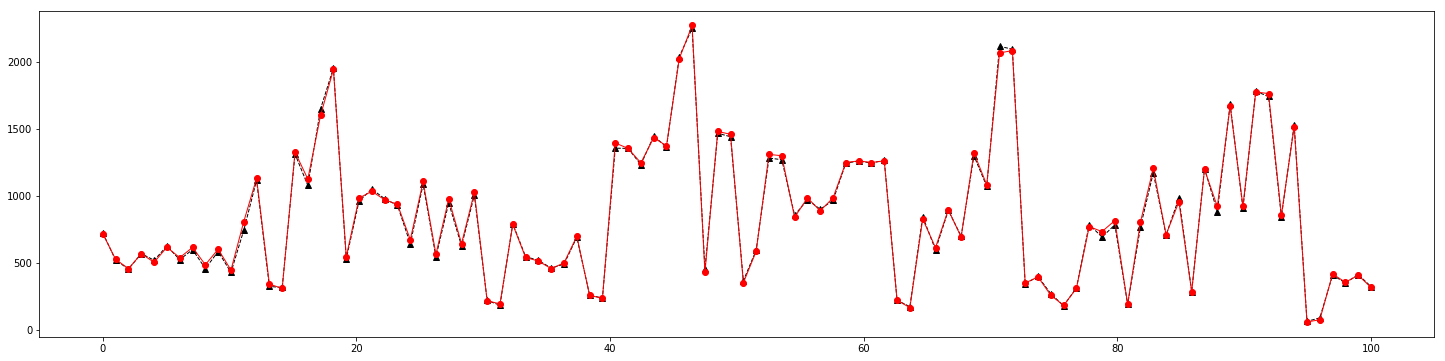

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt

y = y_true.reshape(-1,)[1600:1700]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[1600:1700]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

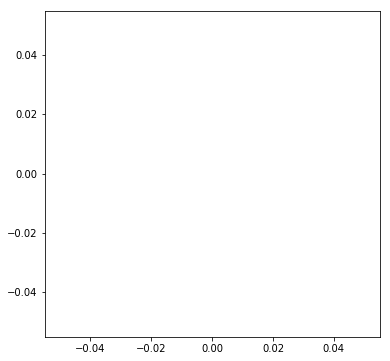

In [25]:
yi = l2_validation
xi = np.linspace(0, len(yi), len(yi))

y = [i*10000 for i in lr_step]
x = np.linspace(0, len(y), len(y))

fig, ax = plt.subplots(figsize=(6, 6))
lines = plt.plot(x, y, 'ko-', xi, yi, 'k^--', linewidth=1, markersize=6)
plt.show()

In [26]:
y = lr_step
x = np.linspace(0, len(y), len(y))
# fig, ax = plt.subplots(figsize=(6, 6))
# lines = plt.plot(x, y, 'ko-', linewidth=1, markersize=6)


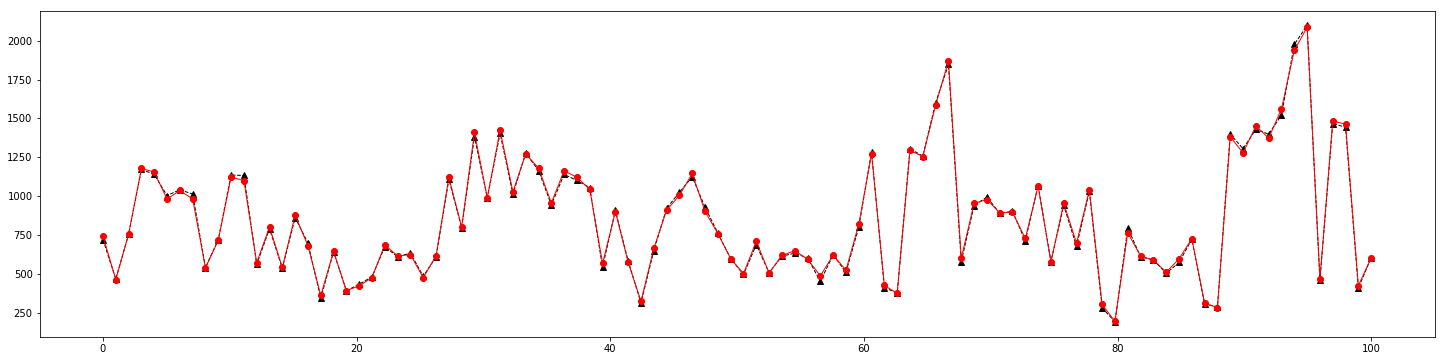

In [27]:
y = y_true.reshape(-1,)[3600:3700]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[3600:3700]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

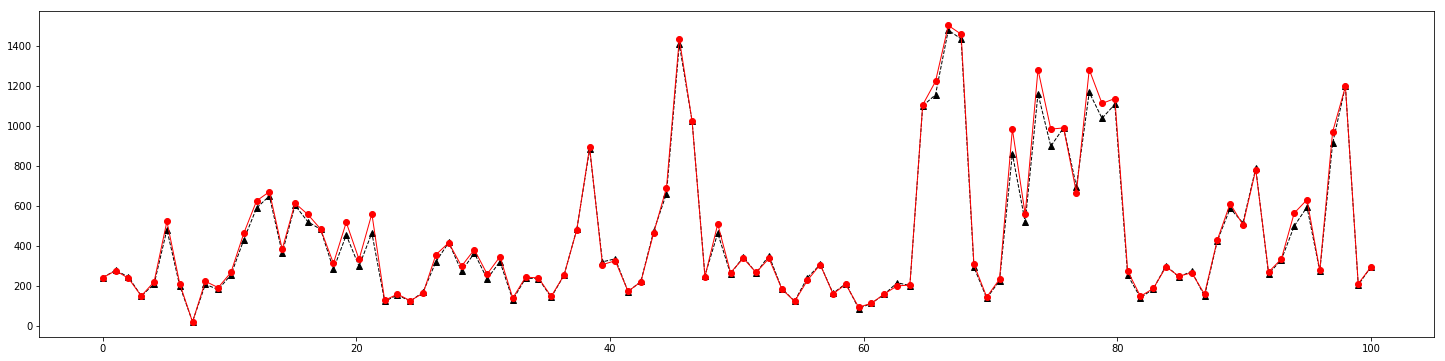

In [28]:
start_time = 0
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

In [29]:
y_pred

array([[[[ 241.4126   ],
         [ 277.81866  ],
         [ 243.65103  ],
         ...,
         [ 363.7049   ],
         [ 234.43158  ],
         [ 321.38644  ]],

        [[ 129.96628  ],
         [ 237.82465  ],
         [ 236.39464  ],
         ...,
         [ 157.03712  ],
         [ 215.33481  ],
         [ 201.34573  ]],

        [[1099.401    ],
         [1155.5496   ],
         [1478.9445   ],
         ...,
         [ 498.08     ],
         [ 593.9738   ],
         [ 273.23376  ]],

        ...,

        [[ 608.3932   ],
         [ 423.2566   ],
         [ 435.52786  ],
         ...,
         [ 108.57626  ],
         [ 142.10158  ],
         [ 153.20952  ]],

        [[1027.4917   ],
         [1264.4093   ],
         [ 995.6248   ],
         ...,
         [ 138.46956  ],
         [ 144.41737  ],
         [ 151.28966  ]],

        [[ 745.1377   ],
         [ 520.9266   ],
         [1140.9071   ],
         ...,
         [ 346.76337  ],
         [ 103.944466 ],
         [ 160.98

In [30]:
y_true

array([[[[ 241.  ],
         [ 275.5 ],
         [ 237.5 ],
         ...,
         [ 381.  ],
         [ 258.5 ],
         [ 345.75]],

        [[ 138.5 ],
         [ 243.25],
         [ 239.5 ],
         ...,
         [ 159.  ],
         [ 199.5 ],
         [ 203.5 ]],

        [[1105.  ],
         [1222.  ],
         [1502.  ],
         ...,
         [ 563.25],
         [ 630.38],
         [ 276.88]],

        ...,

        [[ 614.5 ],
         [ 423.5 ],
         [ 447.  ],
         ...,
         [ 113.5 ],
         [ 151.  ],
         [ 156.5 ]],

        [[1108.  ],
         [1287.  ],
         [1023.25],
         ...,
         [ 132.  ],
         [ 151.  ],
         [ 156.5 ]],

        [[ 737.  ],
         [ 514.25],
         [1133.5 ],
         ...,
         [ 352.5 ],
         [ 118.5 ],
         [ 178.5 ]]],


       [[[ 279.5 ],
         [ 305.  ],
         [ 215.  ],
         ...,
         [ 414.5 ],
         [ 363.  ],
         [ 381.75]],

        [[ 179.  ],
         [ 2